In [ ]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import cv2
import gc
from tqdm import tqdm

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle_api/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c diabetic-retinopathy-detection

100% 82.2G/82.2G [16:41<00:00, 92.2MB/s]
100% 82.2G/82.2G [16:41<00:00, 88.1MB/s]


In [ ]:
!unzip /content/diabetic-retinopathy-detection.zip

Archive:  /content/diabetic-retinopathy-detection.zip
  inflating: sample.zip              
  inflating: sampleSubmission.csv.zip  
  inflating: test.zip.001            
  inflating: test.zip.002            
  inflating: test.zip.003            
  inflating: test.zip.004            
  inflating: test.zip.005            
  inflating: test.zip.006            
  inflating: test.zip.007            
  inflating: train.zip.001           
  inflating: train.zip.002           
  inflating: train.zip.003           
  inflating: train.zip.004           
  inflating: train.zip.005           
  inflating: trainLabels.csv.zip     


In [ ]:
# loading the dataset
train_df = pd.read_csv('/content/trainLabels.csv')

In [ ]:
train_df['image']

,image
0,10_left
1,10_right
2,13_left
3,13_right
4,15_left
...,...
35121,44347_right
35122,44348_left
35123,44348_right
35124,44349_left


In [ ]:
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [ ]:
import pandas as pd
import os
import shutil
#    Sorts images based on labels from a CSV.

def sort_images(csv_path, image_folder, output_folder):
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: CSV file not found at {csv_path}")
        return
    except pd.errors.ParserError:
        print(f"Error: Could not parse CSV file at {csv_path}. Check its format.")
        return

    if not os.path.exists(image_folder):
        print(f"Error: Image folder not found at {image_folder}")
        return

    os.makedirs(output_folder, exist_ok=True)

    for index, row in df.iterrows():
        label = str(row['level'])
        image_name = row['image'] + ".jpeg"
        image_path = os.path.join(image_folder, image_name)

        if not os.path.exists(image_path):
            print(f"Warning: Image {image_name} not found in {image_folder}")
            continue

        label_folder = os.path.join(output_folder, label)
        os.makedirs(label_folder, exist_ok=True)

        output_path = os.path.join(label_folder, image_name)
        try:
            shutil.copy2(image_path, output_path)
            print(f"Moved {image_name} to {label_folder}")
        except Exception as e:
            print(f"Error moving {image_name}: {e}")

csv_file = '/content/trainLabels.csv'
images_dir = '/content/train'
sorted_images_dir = '/content/drive/MyDrive/Dataset'  # Output in the content directory

sort_images(csv_file, images_dir, sorted_images_dir)

In [ ]:
#loading the Sorted dataset
TRAIN_DATA_PATH = '/content/drive/MyDrive/Dataset'


In [ ]:
train_counts = {expression: len(os.listdir(os.path.join(TRAIN_DATA_PATH, expression)))
                for expression in os.listdir(TRAIN_DATA_PATH)}
train_counts_df = pd.DataFrame(train_counts, index=['train'])
print("Number of images in training set:")
print(train_counts_df)

Number of images in training set:
           0     1     2    4    3
train  23286  2203  4825  645  806


Text(0, 0.5, 'Count')

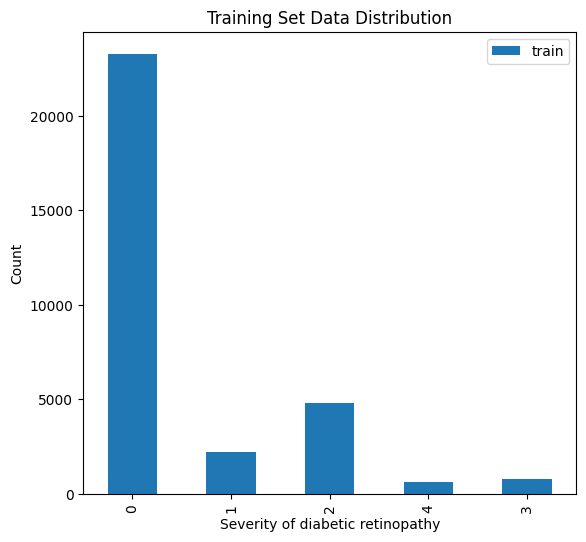

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
train_counts_df.transpose().plot(kind='bar', ax=plt.gca())
plt.title('Training Set Data Distribution')
plt.xlabel('Severity of diabetic retinopathy')
plt.ylabel('Count')

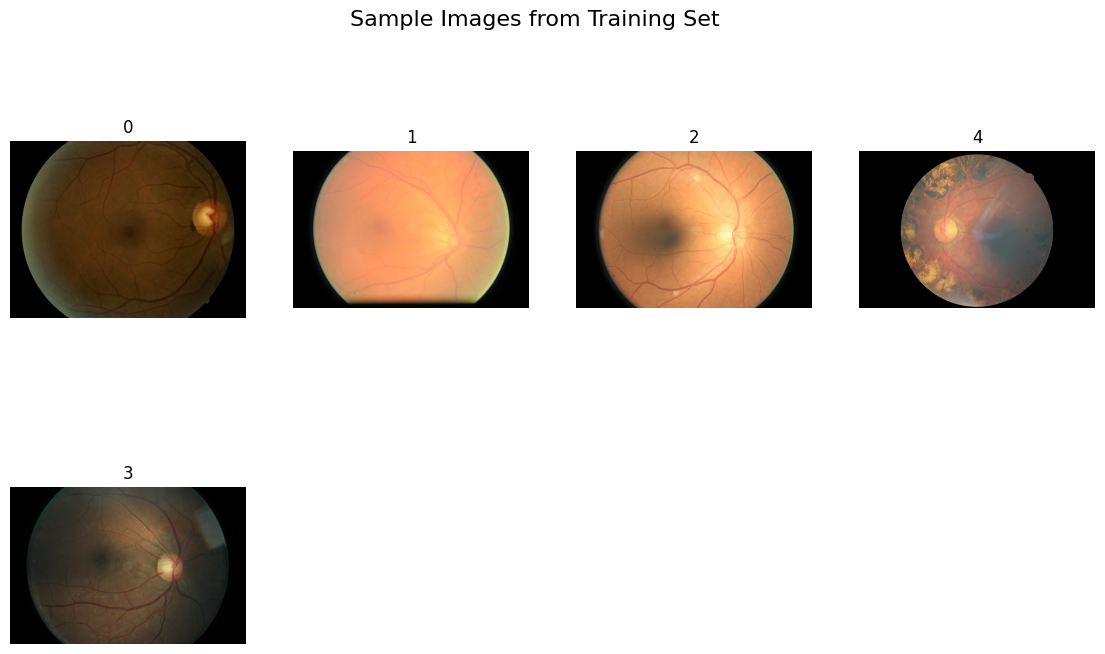

In [ ]:
plt.figure(figsize=(14, 8))
for i, expression in enumerate(os.listdir(TRAIN_DATA_PATH), 1):
    img_path = os.path.join(TRAIN_DATA_PATH, expression, os.listdir(os.path.join(TRAIN_DATA_PATH, expression))[0])
    img = plt.imread(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(expression)
    plt.axis('off')
plt.suptitle('Sample Images from Training Set', fontsize=16)
plt.show()

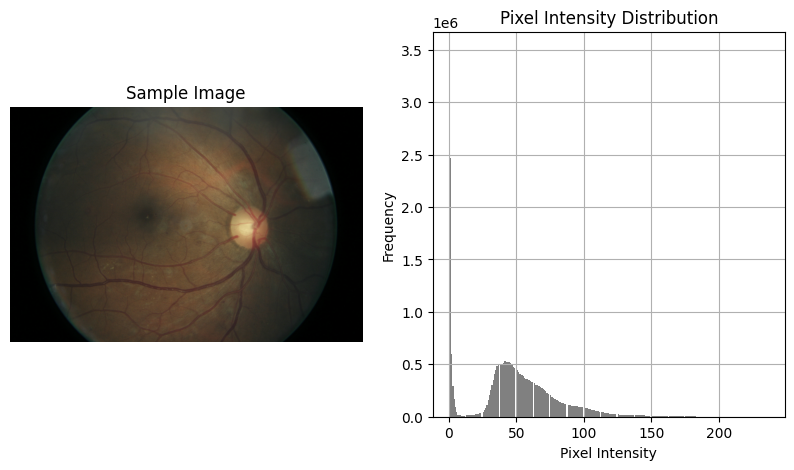

In [ ]:
#Pixel Intensity Distribution
sample_img_path = os.path.join(TRAIN_DATA_PATH, '3', os.listdir(os.path.join(TRAIN_DATA_PATH, '3'))[0])
sample_img = plt.imread(sample_img_path)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img, cmap='gray')
plt.title('Sample Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.hist(sample_img.ravel(), bins=256, color='gray')
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Preprocessing the Image :

In [ ]:
import numpy as np
import cv2

def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Corrected line
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # Image is too dark
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            return np.stack([img1, img2, img3], axis=-1)


In [ ]:
#Applies cropping and resizing to all images in a folder.

def process_images_in_folder(input_folder, output_folder, target_size=(256, 256)):
    if not os.path.exists(input_folder):
        print(f"Error: Input folder not found: {input_folder}")
        return

    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            print(f"Skipping non-image file: {filename}")
            continue

        input_path = os.path.join(input_folder, filename)
        output_filename = "resized_cropped_" + filename
        output_path = os.path.join(output_folder, output_filename)

        try:
            img = cv2.imread(input_path)
            if img is None:
                print(f"Warning: Could not read image: {filename}")
                continue

            cropped_img = crop_image_from_gray(img)

            if cropped_img is not None and cropped_img.size > 0: # Check if cropping was successful and the image is not empty
                resized_img = cv2.resize(cropped_img, target_size)
                cv2.imwrite(output_path, resized_img)
                print(f"Resized and cropped: {filename} to {output_filename}")
            else:
                print(f"Warning: Cropping resulted in an empty image or error for: {filename}")
                continue

        except Exception as e:
            print(f"Error processing {filename}: {e}")

input_folder = '/content/drive/MyDrive/Dataset/0'
output_folder = '/content/drive/MyDrive/Resized/No_DR'
input_folder1 = '/content/drive/MyDrive/Dataset/1'
output_folder1 = '/content/drive/MyDrive/Resized/Mild'
input_folder2 = '/content/drive/MyDrive/Dataset/2'
output_folder2 = '/content/drive/MyDrive/Resized/Moderate'
input_folder3 = '/content/drive/MyDrive/Dataset/3'
output_folder3 = '/content/drive/MyDrive/Resized/Severe'
input_folder4 = '/content/drive/MyDrive/Dataset/4'
output_folder4 = '/content/drive/MyDrive/Resized/Proliferative_DR'
target_size = (128, 128)  # Desired output size (width, height)



In [ ]:
#No_DR
process_images_in_folder(input_folder, output_folder, target_size)

In [ ]:
#Moderate
process_images_in_folder(input_folder1, output_folder1, target_size)

In [ ]:
#Severe
process_images_in_folder(input_folder2, output_folder2, target_size)

In [ ]:
#Mild
process_images_in_folder(input_folder3, output_folder3, target_size)

In [ ]:
#Proliferate_DR
process_images_in_folder(input_folder4, output_folder4, target_size)

In [ ]:
#loading the Processed Dataset
train = '/content/drive/MyDrive/Resized'
train_counts = {expression: len(os.listdir(os.path.join(train, expression)))
                for expression in os.listdir(train)}
train_counts_df = pd.DataFrame(train_counts, index=['train'])
print("Number of images in training set:")
print(train_counts_df)

Number of images in training set:
       No_DR  Mild  Moderate  Severe  Proliferative_DR
train  22286  2203      4825     806               645


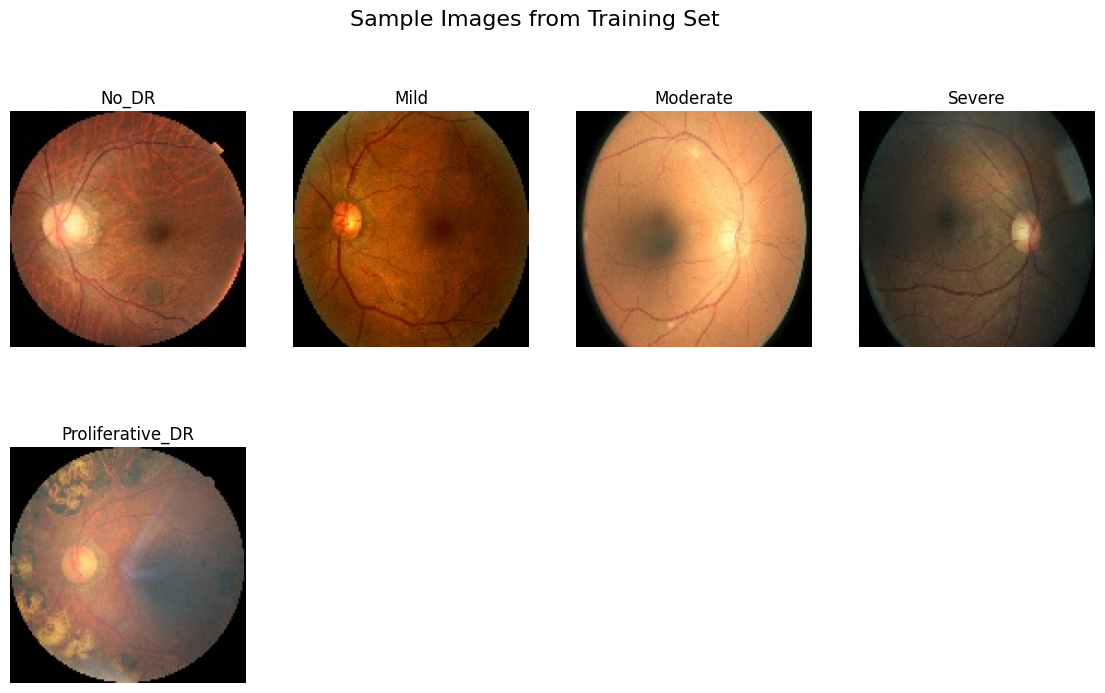

In [ ]:
plt.figure(figsize=(14, 8))
for i, expression in enumerate(os.listdir(train), 1):
    img_path = os.path.join(train, expression, os.listdir(os.path.join(train, expression))[0])
    img = plt.imread(img_path)
    plt.subplot(2, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(expression)
    plt.axis('off')
plt.suptitle('Sample Images from Training Set', fontsize=16)
plt.show()

In [ ]:
#creating the Test dataset and saving in the drive
import os
import shutil

def move_first_n_files(source_folder, destination_folder, n):
    """Moves the first n files from source_folder to destination_folder."""

    if not os.path.exists(source_folder):
        print(f"Source folder '{source_folder}' not found.")
        return

    os.makedirs(destination_folder, exist_ok=True)  # Create destination if it doesn't exist

    files = os.listdir(source_folder)
    num_files_to_move = min(n, len(files))  # Don't try to move more files than exist

    for i in range(num_files_to_move):
        source_path = os.path.join(source_folder, files[i])
        destination_path = os.path.join(destination_folder, files[i])
        try:
            shutil.move(source_path, destination_path)
            print(f"Moved: {files[i]}")
        except Exception as e:
            print(f"Error moving {files[i]}: {e}")

source_folder = "/content/drive/MyDrive/Resized/Severe"  # Replace with your source folder
destination_folder = "/content/drive/MyDrive/Test/Severe"  # Replace with your destination folder
move_first_n_files(source_folder, destination_folder, 80)